YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
<ipython-input-1-b7b360552a34>:121: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(self.df['MA5'].iloc[self.current_step] / self.df['Close'].iloc[self.current_step] - 1),
<ipython-input-1-b7b360552a34>:122: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(self.df['MA10'].iloc[self.current_step] / self.df['Close'].iloc[self.current_step] - 1),
<ipython-input-1-b7b360552a34>:134: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price_change = float((next_price / current_price) - 1)
<ipython-input-1-b7b360552a34>:76: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting th

Episode: 0, Final Portfolio Value: 67695.50
Episode: 2, Final Portfolio Value: 67920.02
Episode: 4, Final Portfolio Value: 136759.46
Episode: 6, Final Portfolio Value: 55515.26
Episode: 8, Final Portfolio Value: 104772.76
Episode: 10, Final Portfolio Value: 78068.48
Episode: 12, Final Portfolio Value: 159720.31
Episode: 14, Final Portfolio Value: 75212.40
Episode: 16, Final Portfolio Value: 105041.06
Episode: 18, Final Portfolio Value: 59561.37
Episode: 20, Final Portfolio Value: 125479.57
Episode: 22, Final Portfolio Value: 94696.23
Episode: 24, Final Portfolio Value: 105787.09
Episode: 26, Final Portfolio Value: 169953.05
Episode: 28, Final Portfolio Value: 157279.78
Episode: 30, Final Portfolio Value: 135421.54
Episode: 32, Final Portfolio Value: 218424.94
Episode: 34, Final Portfolio Value: 229784.86
Episode: 36, Final Portfolio Value: 187166.40
Episode: 38, Final Portfolio Value: 170931.60
Episode: 40, Final Portfolio Value: 211817.00
Episode: 42, Final Portfolio Value: 107157.35


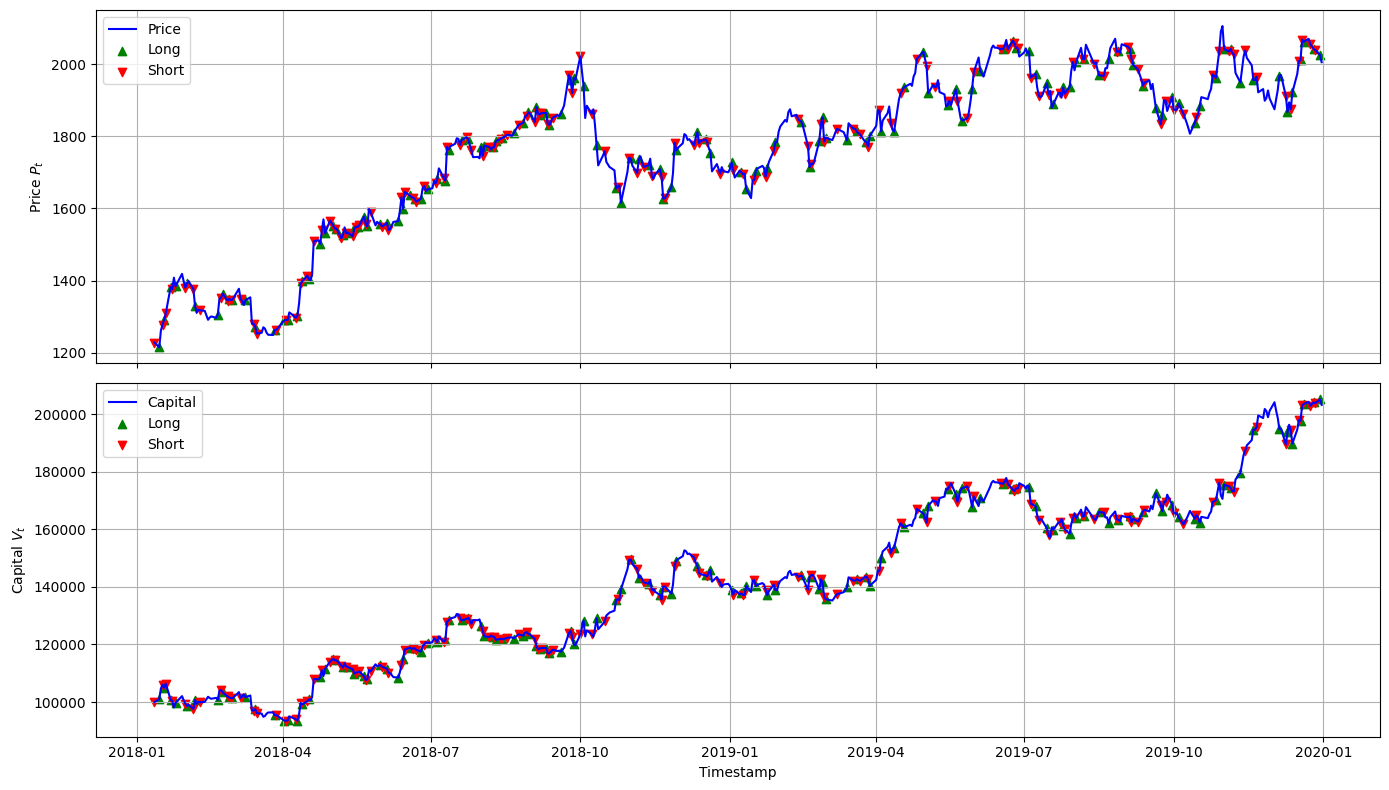

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random

# 1. Load Stock Data
def load_data(ticker='INTC', start='2018-01-01', end='2020-01-01'):
    df = yf.download(ticker, start=start, end=end)
    # Add technical indicators that can be used as features
    df['Returns'] = df['Close'].pct_change()
    # Calculate moving averages
    df['MA5'] = df['Close'].rolling(window=5).mean()
    df['MA10'] = df['Close'].rolling(window=10).mean()
    # Add more features as needed
    df.dropna(inplace=True)
    return df

# 2. Define TDQN Network
class DQNNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQNNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# 3. TDQN Agent
class TDQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=100000)
        self.gamma = 0.6  # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.999
        self.learning_rate = 0.0001
        self.model = DQNNetwork(state_size, action_size)
        self.target_model = DQNNetwork(state_size, action_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.update_target_network()

    def update_target_network(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state, training=True):
        if training and np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)

        state = torch.FloatTensor(state).unsqueeze(0)
        act_values = self.model(state)
        return torch.argmax(act_values).item()

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return

        minibatch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*minibatch)

        states = torch.FloatTensor(states)
        next_states = torch.FloatTensor(next_states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        dones = torch.FloatTensor(dones)

        # Current Q values
        current_q = self.model(states).gather(1, actions.unsqueeze(1)).squeeze(1)

        # Next Q values using target network
        next_q = self.target_model(next_states).max(1)[0]
        target_q = rewards + (1 - dones) * self.gamma * next_q

        # Compute loss
        loss = nn.MSELoss()(current_q, target_q.detach())

        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# 4. Trading Environment
class TradingEnvironment:
    def __init__(self, df, initial_capital=100000):
        self.df = df
        self.initial_capital = initial_capital
        self.reset()

    def reset(self):
        self.position = 0  # 0: no position, 1: long, -1: short
        self.capital = float(self.initial_capital)
        self.current_step = 0
        self.portfolio_values = [float(self.initial_capital)]
        self.buy_signals = []
        self.sell_signals = []
        return self._get_state()

    def _get_state(self):
        # Create state from current data window
        features = [
            float(self.df['Returns'].iloc[self.current_step]),
            float(self.df['MA5'].iloc[self.current_step] / self.df['Close'].iloc[self.current_step] - 1),
            float(self.df['MA10'].iloc[self.current_step] / self.df['Close'].iloc[self.current_step] - 1),
            float(self.position)
        ]
        return np.array(features, dtype=np.float32)

    def step(self, action):
        # 0: short, 1: long
        current_price = self.df['Close'].iloc[self.current_step]

        # Calculate reward based on position and price change
        next_step = min(self.current_step + 1, len(self.df) - 1)
        next_price = self.df['Close'].iloc[next_step]
        price_change = float((next_price / current_price) - 1)

        # Update position based on action
        old_position = self.position
        if action == 0:  # Short
            if old_position != -1:  # Only record if position changes
                self.position = -1
                self.sell_signals.append(self.current_step)
        else:  # Long
            if old_position != 1:  # Only record if position changes
                self.position = 1
                self.buy_signals.append(self.current_step)

        # Calculate reward with higher incentive for correct trades
        if (self.position == 1 and price_change > 0) or (self.position == -1 and price_change < 0):
            reward = abs(price_change) * 2  # Bonus for correct direction
        else:
            reward = self.position * price_change

        # Update capital with more realistic returns
        self.capital *= (1 + self.position * price_change * 0.95)  # 0.95 to account for slippage/fees
        self.portfolio_values.append(float(self.capital))

        # Move to next step
        self.current_step += 1
        done = self.current_step >= len(self.df) - 1

        return self._get_state(), reward, done, {}

# 5. Train TDQN Agent
def train_tdqn_agent(df, episodes=100):
    # Define state and action sizes
    state_size = 4  # Adjust based on your features
    action_size = 2  # Long or Short

    # Create agent and environment
    agent = TDQNAgent(state_size, action_size)
    env = TradingEnvironment(df)

    batch_size = 32

    for episode in range(episodes):
        state = env.reset()
        done = False

        while not done:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            agent.remember(state, action, reward, next_state, done)
            state = next_state

            # Train the agent
            if len(agent.memory) > batch_size:
                agent.replay(batch_size)

        # Update target network periodically
        if episode % 2 == 0:
            agent.update_target_network()

        # Print progress
        if episode % 2 == 0:
            print(f"Episode: {episode}, Final Portfolio Value: {float(env.capital):.2f}")

    return agent, env

# 6. Generate Signals with Trained Agent
def generate_signals_with_tdqn(df, agent):
    env = TradingEnvironment(df)
    state = env.reset()
    done = False

    while not done:
        action = agent.act(state, training=False)
        next_state, _, done, _ = env.step(action)
        state = next_state

    # Ensure portfolio_values has the same length as df
    portfolio_values = env.portfolio_values
    if len(portfolio_values) < len(df):
        portfolio_values.append(portfolio_values[-1])  # Duplicate last value if needed

    return env.buy_signals, env.sell_signals, np.array(portfolio_values, dtype=float)

# 7. Plot Function (unchanged)
def plot_dual_panel(df, buy_signals, sell_signals, portfolio):
    dates = df.index
    prices = df['Close'].values

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

    # Top: Price
    ax1.plot(dates, prices, label='Price', color='blue')
    ax1.scatter(dates[buy_signals], prices[buy_signals], color='green', marker='^', label='Long')
    ax1.scatter(dates[sell_signals], prices[sell_signals], color='red', marker='v', label='Short')
    ax1.set_ylabel('Price $P_t$')
    ax1.legend()
    ax1.grid(True)

    # Bottom: Portfolio Value
    ax2.plot(dates, portfolio, label='Capital', color='blue')  # Remove the [:-1] slicing
    ax2.scatter(dates[buy_signals], portfolio[buy_signals], color='green', marker='^', label='Long')
    ax2.scatter(dates[sell_signals], portfolio[sell_signals], color='red', marker='v', label='Short')
    ax2.set_ylabel('Capital $V_t$')
    ax2.set_xlabel('Timestamp')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# Run
ticker = 'TCS.NS'
df = load_data(ticker, start='2018-01-01', end='2020-01-01')

# Train the TDQN agent
agent, _ = train_tdqn_agent(df, episodes=100)

# Generate signals with trained agent
buy_signals, sell_signals, portfolio = generate_signals_with_tdqn(df, agent)

# Plot results
plot_dual_panel(df, buy_signals, sell_signals, portfolio)

[*********************100%***********************]  1 of 1 completed
<ipython-input-2-8f4cc92db577>:132: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(self.df['MA5'].iloc[self.current_step] / self.df['Close'].iloc[self.current_step] - 1),
<ipython-input-2-8f4cc92db577>:133: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(self.df['MA10'].iloc[self.current_step] / self.df['Close'].iloc[self.current_step] - 1),
<ipython-input-2-8f4cc92db577>:142: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price_change = float((next_price / current_price) - 1)


Episode: 0, Final Portfolio Value: 75304.78
Episode: 2, Final Portfolio Value: 98211.60
Episode: 4, Final Portfolio Value: 75589.34
Episode: 6, Final Portfolio Value: 114197.43
Episode: 8, Final Portfolio Value: 76787.72
Episode: 10, Final Portfolio Value: 173579.06
Episode: 12, Final Portfolio Value: 107627.63
Episode: 14, Final Portfolio Value: 70711.82
Episode: 16, Final Portfolio Value: 75242.47
Episode: 18, Final Portfolio Value: 113845.86
Episode: 20, Final Portfolio Value: 72309.61
Episode: 22, Final Portfolio Value: 90498.42
Episode: 24, Final Portfolio Value: 135109.72
Episode: 26, Final Portfolio Value: 193209.37
Episode: 28, Final Portfolio Value: 232348.89
Episode: 30, Final Portfolio Value: 119852.70
Episode: 32, Final Portfolio Value: 119014.15
Episode: 34, Final Portfolio Value: 190401.50
Episode: 36, Final Portfolio Value: 119236.30
Episode: 38, Final Portfolio Value: 165392.66
Episode: 40, Final Portfolio Value: 180732.53
Episode: 42, Final Portfolio Value: 216917.48
E

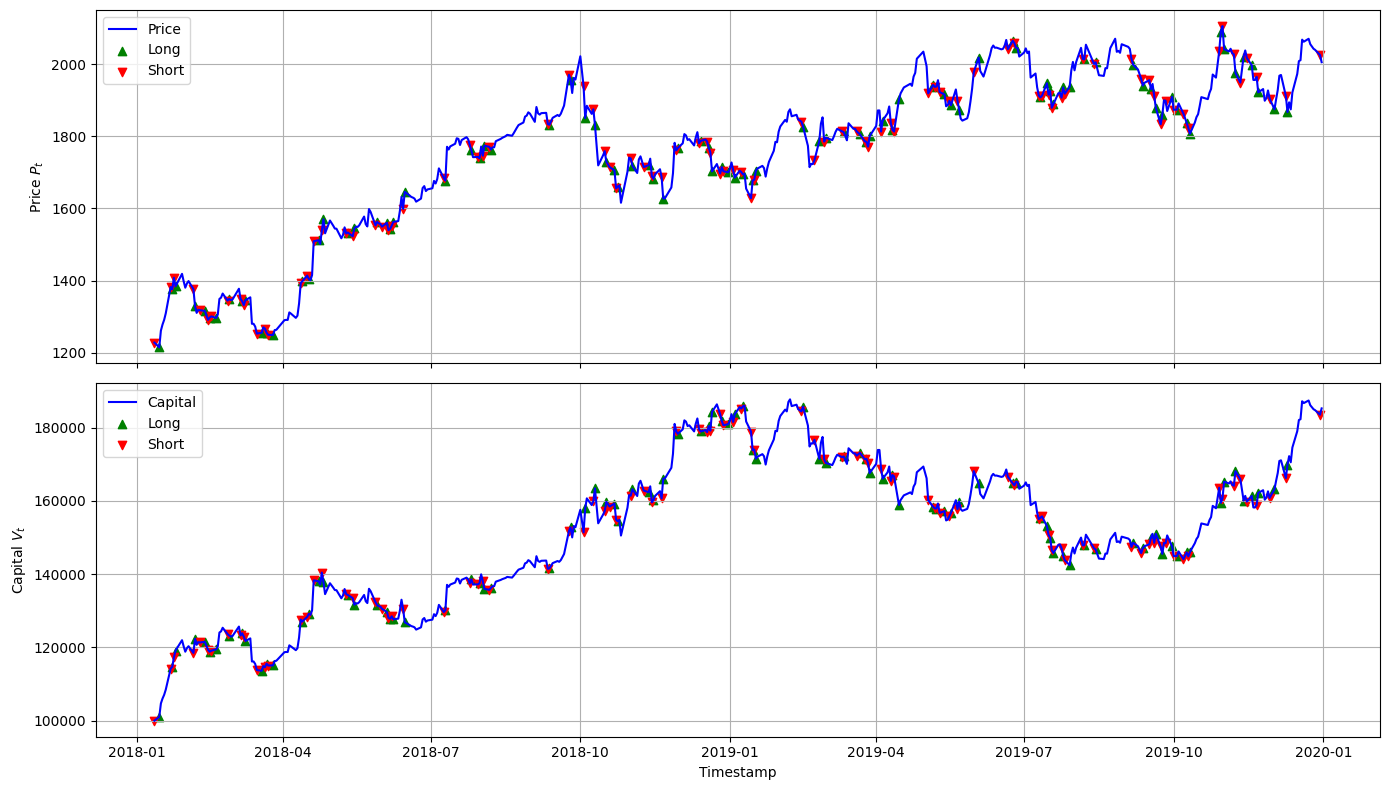

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import os

# Set random seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# 1. Load Stock Data
def load_data(ticker='TCS.NS', start='2018-01-01', end='2020-01-01'):
    df = yf.download(ticker, start=start, end=end)
    # Add technical indicators that can be used as features
    df['Returns'] = df['Close'].pct_change()
    # Calculate moving averages
    df['MA5'] = df['Close'].rolling(window=5).mean()
    df['MA10'] = df['Close'].rolling(window=10).mean()
    # Add more features as needed
    df.dropna(inplace=True)
    return df

# 2. Define TDQN Network
class DQNNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQNNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# 3. TDQN Agent
class TDQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=100000)
        self.gamma = 0.6  # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.999
        self.learning_rate = 0.0001
        self.model = DQNNetwork(state_size, action_size)
        self.target_model = DQNNetwork(state_size, action_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.update_target_network()

    def update_target_network(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state, training=True):
        if training and np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)

        state = torch.FloatTensor(state).unsqueeze(0)
        act_values = self.model(state)
        return torch.argmax(act_values).item()

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return

        minibatch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*minibatch)

        states = torch.FloatTensor(states)
        next_states = torch.FloatTensor(next_states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        dones = torch.FloatTensor(dones)

        # Current Q values
        current_q = self.model(states).gather(1, actions.unsqueeze(1)).squeeze(1)

        # Next Q values using target network
        next_q = self.target_model(next_states).max(1)[0]
        target_q = rewards + (1 - dones) * self.gamma * next_q

        # Compute loss
        loss = nn.MSELoss()(current_q, target_q.detach())

        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# 4. Trading Environment
class TradingEnvironment:
    def __init__(self, df, initial_capital=100000):
        self.df = df
        self.initial_capital = initial_capital
        self.reset()

    def reset(self):
        self.position = 0  # 0: no position, 1: long, -1: short
        self.capital = float(self.initial_capital)
        self.current_step = 0
        self.portfolio_values = [float(self.initial_capital)]
        self.buy_signals = []
        self.sell_signals = []
        return self._get_state()

    def _get_state(self):
        features = [
            float(self.df['Returns'].iloc[self.current_step]),
            float(self.df['MA5'].iloc[self.current_step] / self.df['Close'].iloc[self.current_step] - 1),
            float(self.df['MA10'].iloc[self.current_step] / self.df['Close'].iloc[self.current_step] - 1),
            float(self.position)
        ]
        return np.array(features, dtype=np.float32)

    def step(self, action):
        current_price = self.df['Close'].iloc[self.current_step]
        next_step = min(self.current_step + 1, len(self.df) - 1)
        next_price = self.df['Close'].iloc[next_step]
        price_change = float((next_price / current_price) - 1)

        old_position = self.position
        if action == 0:  # Short
            if old_position != -1:
                self.position = -1
                self.sell_signals.append(self.current_step)
        else:  # Long
            if old_position != 1:
                self.position = 1
                self.buy_signals.append(self.current_step)

        if (self.position == 1 and price_change > 0) or (self.position == -1 and price_change < 0):
            reward = abs(price_change) * 2
        else:
            reward = self.position * price_change

        self.capital *= (1 + self.position * price_change * 0.95)
        self.portfolio_values.append(float(self.capital))

        self.current_step += 1
        done = self.current_step >= len(self.df) - 1

        return self._get_state(), reward, done, {}

# 5. Train TDQN Agent
def train_tdqn_agent(df, episodes=100):
    state_size = 4
    action_size = 2
    agent = TDQNAgent(state_size, action_size)
    env = TradingEnvironment(df)
    batch_size = 32

    for episode in range(episodes):
        state = env.reset()
        done = False

        while not done:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            agent.remember(state, action, reward, next_state, done)
            state = next_state

            if len(agent.memory) > batch_size:
                agent.replay(batch_size)

        if episode % 2 == 0:
            agent.update_target_network()

        if episode % 2 == 0:
            print(f"Episode: {episode}, Final Portfolio Value: {float(env.capital):.2f}")

    return agent, env

# 6. Generate Signals with Trained Agent
def generate_signals_with_tdqn(df, agent):
    env = TradingEnvironment(df)
    state = env.reset()
    done = False

    while not done:
        action = agent.act(state, training=False)
        next_state, _, done, _ = env.step(action)
        state = next_state

    portfolio_values = env.portfolio_values
    if len(portfolio_values) < len(df):
        portfolio_values.append(portfolio_values[-1])

    return env.buy_signals, env.sell_signals, np.array(portfolio_values, dtype=float)

# 7. Plot Function
def plot_dual_panel(df, buy_signals, sell_signals, portfolio):
    dates = df.index
    prices = df['Close'].values

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

    ax1.plot(dates, prices, label='Price', color='blue')
    ax1.scatter(dates[buy_signals], prices[buy_signals], color='green', marker='^', label='Long')
    ax1.scatter(dates[sell_signals], prices[sell_signals], color='red', marker='v', label='Short')
    ax1.set_ylabel('Price $P_t$')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(dates, portfolio, label='Capital', color='blue')
    ax2.scatter(dates[buy_signals], portfolio[buy_signals], color='green', marker='^', label='Long')
    ax2.scatter(dates[sell_signals], portfolio[sell_signals], color='red', marker='v', label='Short')
    ax2.set_ylabel('Capital $V_t$')
    ax2.set_xlabel('Timestamp')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# Run
ticker = 'TCS.NS'
df = load_data(ticker, start='2018-01-01', end='2020-01-01')

# Train the TDQN agent
agent, _ = train_tdqn_agent(df, episodes=100)

# Generate signals with trained agent
buy_signals, sell_signals, portfolio = generate_signals_with_tdqn(df, agent)

# Plot results
plot_dual_panel(df, buy_signals, sell_signals, portfolio)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import os

# Set random seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# 1. Load Stock Data
def load_data(ticker='TCS.NS', start='2018-01-01', end='2020-01-01'):
    df = yf.download(ticker, start=start, end=end)
    # Add technical indicators that can be used as features
    df['Returns'] = df['Close'].pct_change()
    # Calculate moving averages
    df['MA5'] = df['Close'].rolling(window=5).mean()
    df['MA10'] = df['Close'].rolling(window=10).mean()
    # Add more features as needed
    df.dropna(inplace=True)
    return df

# 2. Define TDQN Network
class DQNNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQNNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# 3. TDQN Agent
class TDQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=100000)
        self.gamma = 0.6  # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.999
        self.learning_rate = 0.0001
        self.model = DQNNetwork(state_size, action_size)
        self.target_model = DQNNetwork(state_size, action_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.update_target_network()

    def update_target_network(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state, training=True):
        if training and np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)

        state = torch.FloatTensor(state).unsqueeze(0)
        act_values = self.model(state)
        return torch.argmax(act_values).item()

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return

        minibatch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*minibatch)

        states = torch.FloatTensor(states)
        next_states = torch.FloatTensor(next_states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        dones = torch.FloatTensor(dones)

        # Current Q values
        current_q = self.model(states).gather(1, actions.unsqueeze(1)).squeeze(1)

        # Next Q values using target network
        next_q = self.target_model(next_states).max(1)[0]
        target_q = rewards + (1 - dones) * self.gamma * next_q

        # Compute loss
        loss = nn.MSELoss()(current_q, target_q.detach())

        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# 4. Trading Environment
class TradingEnvironment:
    def __init__(self, df, initial_capital=100000):
        self.df = df
        self.initial_capital = initial_capital
        self.reset()

    def reset(self):
        self.position = 0  # 0: no position, 1: long, -1: short
        self.capital = float(self.initial_capital)
        self.current_step = 0
        self.portfolio_values = [float(self.initial_capital)]
        self.buy_signals = []
        self.sell_signals = []
        return self._get_state()

    def _get_state(self):
        features = [
            float(self.df['Returns'].iloc[self.current_step]),
            float(self.df['MA5'].iloc[self.current_step] / self.df['Close'].iloc[self.current_step] - 1),
            float(self.df['MA10'].iloc[self.current_step] / self.df['Close'].iloc[self.current_step] - 1),
            float(self.position)
        ]
        return np.array(features, dtype=np.float32)

    def step(self, action):
        current_price = self.df['Close'].iloc[self.current_step]
        next_step = min(self.current_step + 1, len(self.df) - 1)
        next_price = self.df['Close'].iloc[next_step]
        price_change = float((next_price / current_price) - 1)

        old_position = self.position
        if action == 0:  # Short
            if old_position != -1:
                self.position = -1
                self.sell_signals.append(self.current_step)
        else:  # Long
            if old_position != 1:
                self.position = 1
                self.buy_signals.append(self.current_step)

        if (self.position == 1 and price_change > 0) or (self.position == -1 and price_change < 0):
            reward = abs(price_change) * 2
        else:
            reward = self.position * price_change

        self.capital *= (1 + self.position * price_change * 0.95)
        self.portfolio_values.append(float(self.capital))

        self.current_step += 1
        done = self.current_step >= len(self.df) - 1

        return self._get_state(), reward, done, {}

# 5. Train TDQN Agent
def train_tdqn_agent(df, episodes=100):
    state_size = 4
    action_size = 2
    agent = TDQNAgent(state_size, action_size)
    env = TradingEnvironment(df)
    batch_size = 32

    for episode in range(episodes):
        state = env.reset()
        done = False

        while not done:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            agent.remember(state, action, reward, next_state, done)
            state = next_state

            if len(agent.memory) > batch_size:
                agent.replay(batch_size)

        if episode % 2 == 0:
            agent.update_target_network()

        if episode % 2 == 0:
            print(f"Episode: {episode}, Final Portfolio Value: {float(env.capital):.2f}")

    return agent, env

# 6. Generate Signals with Trained Agent
def generate_signals_with_tdqn(df, agent):
    env = TradingEnvironment(df)
    state = env.reset()
    done = False

    while not done:
        action = agent.act(state, training=False)
        next_state, _, done, _ = env.step(action)
        state = next_state

    portfolio_values = env.portfolio_values
    if len(portfolio_values) < len(df):
        portfolio_values.append(portfolio_values[-1])

    return env.buy_signals, env.sell_signals, np.array(portfolio_values, dtype=float)

# 7. Plot Function
def plot_dual_panel(df, buy_signals, sell_signals, portfolio):
    dates = df.index
    prices = df['Close'].values

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

    ax1.plot(dates, prices, label='Price', color='blue')
    ax1.scatter(dates[buy_signals], prices[buy_signals], color='green', marker='^', label='Long')
    ax1.scatter(dates[sell_signals], prices[sell_signals], color='red', marker='v', label='Short')
    ax1.set_ylabel('Price $P_t$')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(dates, portfolio, label='Capital', color='blue')
    ax2.scatter(dates[buy_signals], portfolio[buy_signals], color='green', marker='^', label='Long')
    ax2.scatter(dates[sell_signals], portfolio[sell_signals], color='red', marker='v', label='Short')
    ax2.set_ylabel('Capital $V_t$')
    ax2.set_xlabel('Timestamp')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# Run
ticker = 'TCS.NS'
df = load_data(ticker, start='2018-01-01', end='2020-01-01')

# Train the TDQN agent
agent, _ = train_tdqn_agent(df, episodes=100)

# Generate signals with trained agent
buy_signals, sell_signals, portfolio = generate_signals_with_tdqn(df, agent)

# Plot results
plot_dual_panel(df, buy_signals, sell_signals, portfolio)

# --- Evaluation Metrics ---

def calculate_direction_accuracy(df, agent):
    env = TradingEnvironment(df)
    state = env.reset()
    correct = 0
    total = 0

    while True:
        action = agent.act(state, training=False)
        next_state, _, done, _ = env.step(action)

        if env.current_step >= len(df):
            break

        price_today = float(df['Close'].iloc[env.current_step - 1])
        price_tomorrow = float(df['Close'].iloc[env.current_step])
        actual_direction = 1 if price_tomorrow > price_today else 0
        predicted_direction = 1 if action == 1 else 0

        if predicted_direction == actual_direction:
            correct += 1
        total += 1

        state = next_state
        if done:
            break

    accuracy = correct / total
    print(f"Directional Accuracy: {accuracy:.2%}")
    return accuracy

def cumulative_return(portfolio):
    return (portfolio[-1] / portfolio[0]) - 1

def sharpe_ratio(portfolio):
    returns = np.diff(portfolio) / portfolio[:-1]
    if returns.std() == 0:
        return 0
    return (returns.mean() / returns.std()) * np.sqrt(252)

def max_drawdown(portfolio):
    cum_max = np.maximum.accumulate(portfolio)
    drawdown = (portfolio - cum_max) / cum_max
    return drawdown.min()

# --- Run Evaluation ---
directional_acc = calculate_direction_accuracy(df, agent)
cum_return = cumulative_return(portfolio)
sharpe = sharpe_ratio(portfolio)
drawdown = max_drawdown(portfolio)

print(f"Cumulative Return: {cum_return:.2%}")
print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Max Drawdown: {drawdown:.2%}")


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
<ipython-input-1-2a06742052a7>:132: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(self.df['MA5'].iloc[self.current_step] / self.df['Close'].iloc[self.current_step] - 1),
<ipython-input-1-2a06742052a7>:133: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(self.df['MA10'].iloc[self.current_step] / self.df['Close'].iloc[self.current_step] - 1),
<ipython-input-1-2a06742052a7>:142: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price_change = float((next_price / current_price) - 1)
<ipython-input-1-2a06742052a7>:88: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting th

Episode: 0, Final Portfolio Value: 76560.49
Episode: 2, Final Portfolio Value: 103987.34
Episode: 4, Final Portfolio Value: 124713.65
Episode: 6, Final Portfolio Value: 139676.32
Episode: 8, Final Portfolio Value: 134298.34
Episode: 10, Final Portfolio Value: 90730.03
Episode: 12, Final Portfolio Value: 84740.79
Episode: 14, Final Portfolio Value: 172641.81
Episode: 16, Final Portfolio Value: 161787.64
Episode: 18, Final Portfolio Value: 140514.12
Episode: 20, Final Portfolio Value: 119481.95
Episode: 22, Final Portfolio Value: 85713.53
Episode: 24, Final Portfolio Value: 210704.85
Episode: 26, Final Portfolio Value: 88481.00
Episode: 28, Final Portfolio Value: 193455.33
Episode: 30, Final Portfolio Value: 168495.02
Episode: 32, Final Portfolio Value: 154923.69
Episode: 34, Final Portfolio Value: 202308.95
Episode: 36, Final Portfolio Value: 191199.25
Episode: 38, Final Portfolio Value: 139851.52
Episode: 40, Final Portfolio Value: 91967.19
Episode: 42, Final Portfolio Value: 153694.62